In [84]:
import pandas as pd
import numpy as np

np.random.seed(1)
# x1 = pd.DataFrame(np.random.normal(loc=np.array([np.pi, 0]), scale=np.array([[np.pi/6, np.pi/2]]), size=(1000,2)))
# x2 = pd.DataFrame(np.random.normal(loc=np.array([0, 0]), scale=np.array([[np.pi/16, np.pi/2]]), size=(1000,2)))
x1 = pd.DataFrame(np.random.normal(loc=np.array([np.pi]), scale=np.array([np.pi/8]), size=(1000,1)))
x2 = pd.DataFrame(np.random.normal(loc=np.array([0]), scale=np.array([np.pi/6]), size=(1000,1)))

In [85]:
x1 = x1 % (2 * np.pi)
x2 = x2 % (2 * np.pi)

In [86]:
X1 = pd.concat([np.cos(x1[0]),  np.sin(x1[0])], axis=1, keys=["x", "y"])
X2 = pd.concat([np.cos(x2[0]),  np.sin(x2[0])], axis=1, keys=["x", "y"])
# X2 = pd.concat([np.sin(x2[0]) * np.cos(x2[1]), np.sin(x2[0]) * np.sin(x2[1]), np.cos(x2[0])], axis=1, keys=[0,1,2])

# X = pd.concat([X1, X2], keys=["data1", "data2"], axis=1)

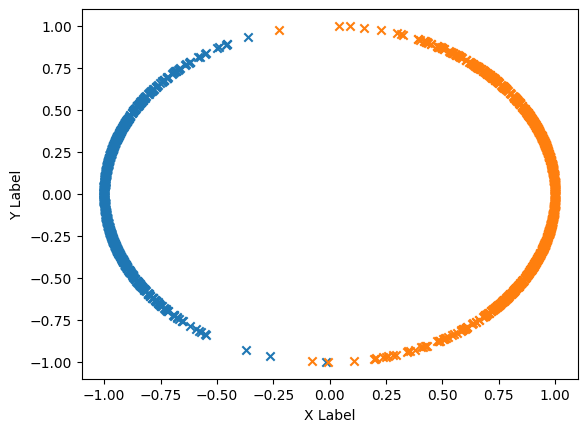

In [99]:
import matplotlib.pyplot as plt
# Fixing random state for reproducibility


fig, ax = plt.subplots()
# fig = plt.figure()

ax.scatter(X1["x"], X1["y"], marker="x")
ax.scatter(X2["x"], X2["y"], marker="x")
# ax.scatter(X2[0], X2[1], X2[2], color="orange", marker="x")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

plt.show()

In [66]:
X.to_parquet("./cartesian_data.parquet")

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

In [70]:
!pip install imageio

   ---------------------------------------- 0.0/315.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/315.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/315.4 kB ? eta -:--:--
   - -------------------------------------- 10.2/315.4 kB ? eta -:--:--
   ----- --------------------------------- 41.0/315.4 kB 388.9 kB/s eta 0:00:01
   ------------------ --------------------- 143.4/315.4 kB 1.1 MB/s eta 0:00:01
   -------------------------------------- - 307.2/315.4 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 315.4/315.4 kB 1.6 MB/s eta 0:00:00


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from geomloss import SamplesLoss

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [71]:
from random import choices
from imageio import imread


def load_image(fname):
    img = imread(fname, as_gray=True)  # Grayscale
    img = (img[::-1, :]) / 255.0
    return 1 - img


def draw_samples(fname, n, dtype=torch.FloatTensor):
    A = load_image(fname)
    xg, yg = np.meshgrid(
        np.linspace(0, 1, A.shape[0]),
        np.linspace(0, 1, A.shape[1]),
        indexing="xy",
    )

    grid = list(zip(xg.ravel(), yg.ravel()))
    dens = A.ravel() / A.sum()
    dots = np.array(choices(grid, dens, k=n))
    dots += (0.5 / A.shape[0]) * np.random.standard_normal(dots.shape)

    return torch.from_numpy(dots).type(dtype)


def display_samples(ax, x, color):
    x_ = x.detach().cpu().numpy()
    ax.scatter(x_[:, 0], x_[:, 1], 25 * 500 / len(x_), color, edgecolors="none")

In [95]:
X_i = torch.tensor(X1.values)
Y_j = torch.tensor(X2.values)

tensor([[-0.8034, -0.5955],
        [-0.9713,  0.2379],
        [-0.9786,  0.2059],
        ...,
        [-0.9996,  0.0273],
        [-0.9904, -0.1385],
        [-0.9973,  0.0734]], dtype=torch.float64)

In [102]:
def gradient_descent(loss, lr=1):
    """Flows along the gradient of the loss function.

    Parameters:
        loss ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        lr (float, default = 1):
            Learning rate, i.e. time step.
    """

    # Parameters for the gradient descent
    Nsteps = 31
    display_its = [0, 1, 2, 30]

    # Use colors to identify the particles
    colors = (10 * X_i[:, 0]).cos() * (10 * X_i[:, 1]).cos()
    colors = colors.detach().cpu().numpy()

    # Make sure that we won't modify the reference samples
    x_i, y_j = X_i.clone(), Y_j.clone()

    # We're going to perform gradient descent on Loss(α, β)
    # wrt. the positions x_i of the diracs masses that make up α:
    x_i.requires_grad = True

    t_0 = time.time()
    plt.figure(figsize=(12, 12))
    k = 1
    for i in range(Nsteps):  # Euler scheme ===============
        # Compute cost and gradient
        L_ab = loss(x_i, y_j)
        [g] = torch.autograd.grad(L_ab, [x_i])

        if i in display_its:  # display
            ax = plt.subplot(2, 2, k)
            k = k + 1
            plt.set_cmap("hsv")
            plt.scatter(
                [10], [10]
            )  # shameless hack to prevent a slight change of axis...

            display_samples(ax, y_j, [(0.55, 0.55, 0.95)])
            display_samples(ax, x_i, colors)

            ax.set_title("it = {}".format(i))

            plt.axis([-1, 1, -1, 1])
            plt.gca().set_aspect("equal", adjustable="box")
            plt.xticks([], [])
            plt.yticks([], [])
            plt.tight_layout()

        # in-place modification of the tensor's values
        x_i.data -= lr * len(x_i) * g
    plt.title(
        "it = {}, elapsed time: {:.2f}s/it".format(i, (time.time() - t_0) / Nsteps)
    )
    plt.savefig("./test.png")

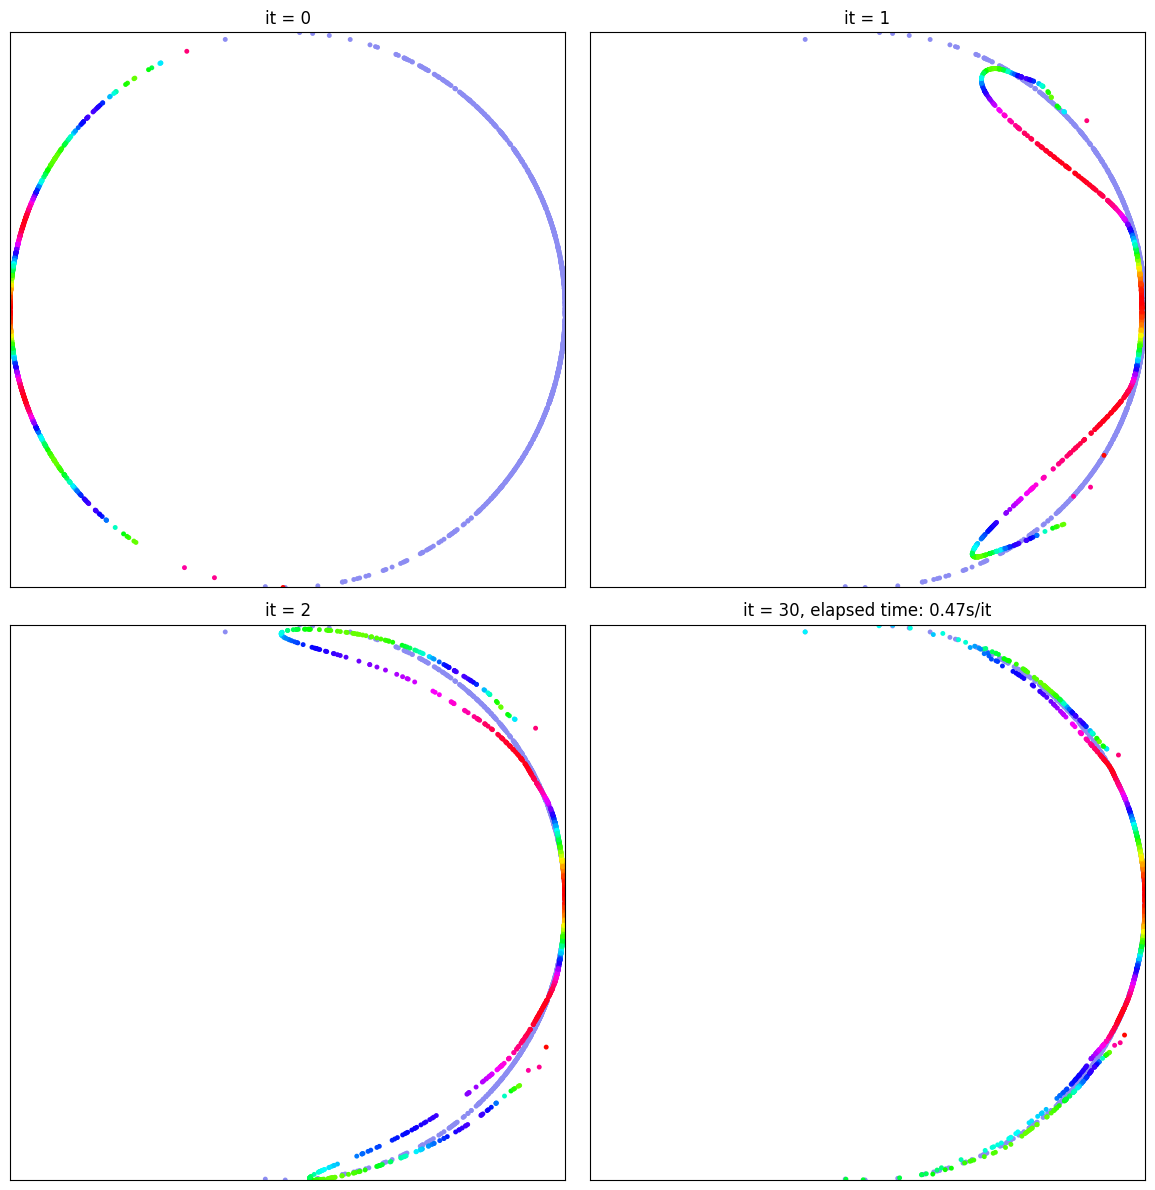

In [103]:
gradient_descent(SamplesLoss("sinkhorn", p=2, blur=0.1))